# Y3891128

In [1]:
!pip install -Uqq ruptures
!pip install -Uqq torch

In [2]:
%matplotlib inline
import time
import os
import math
import random
import pickle
import turtle

from operator import attrgetter
from functools import partial
from pathlib import Path
import IPython

from deap import base, creator, tools

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt # change point detection for stats

## SnakeProblem code

In [3]:
XSIZE = YSIZE = 16

In [4]:
class DisplayGame:
    def __init__(self, XSIZE, YSIZE):
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVCO Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE * 20) + 40, height=(YSIZE * 20) + 40)
        # self.win.screensize((XSIZE*20)+20,(YSIZE*20)+20)
        self.win.tracer(0)

        # Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("yellow")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake) - 1):
            self.add_snake_segment()
        self.update_segment_positions(snake)

    def update_food(self, new_food):
        self.food.goto(
            ((new_food[1] - 9) * 20) + 20, (((9 - new_food[0]) * 20) - 10) - 20
        )

    def update_segment_positions(self, snake):
        self.head.goto(
            ((snake[0][1] - 9) * 20) + 20, (((9 - snake[0][0]) * 20) - 10) - 20
        )
        for i in range(len(self.segments)):
            self.segments[i].goto(
                ((snake[i + 1][1] - 9) * 20) + 20,
                (((9 - snake[i + 1][0]) * 20) - 10) - 20,
            )

    def add_snake_segment(self):
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color(random.choice(["green", "black", "red", "blue"]))
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [5]:
class snake:
    def __init__(self, _XSIZE, _YSIZE):
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        self.snake = [
            [8, 10],
            [8, 9],
            [8, 8],
            [8, 7],
            [8, 6],
            [8, 5],
            [8, 4],
            [8, 3],
            [8, 2],
            [8, 1],
            [8, 0],
        ]  # Initial snake co-ordinates [ypos,xpos]
        self.food = self.place_food()
        self.ahead = []
        self.snake_direction = "right"

    def place_food(self):
        self.food = [random.randint(1, (YSIZE - 2)), random.randint(1, (XSIZE - 2))]
        while self.food in self.snake:
            self.food = [random.randint(1, (YSIZE - 2)), random.randint(1, (XSIZE - 2))]
        return self.food

    def update_snake_position(self):
        self.snake.insert(
            0,
            [
                self.snake[0][0]
                + (self.snake_direction == "down" and 1)
                + (self.snake_direction == "up" and -1),
                self.snake[0][1]
                + (self.snake_direction == "left" and -1)
                + (self.snake_direction == "right" and 1),
            ],
        )

    def food_eaten(self):
        if self.snake[0] == self.food:  # When snake eats the food
            return True
        else:
            last = (
                self.snake.pop()
            )  # [1] If it does not eat the food, it moves forward and so last tail item is removed
            return False

    def snake_turns_into_self(self):
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        if (
            self.snake[0][0] == 0
            or self.snake[0][0] == (YSIZE - 1)
            or self.snake[0][1] == 0
            or self.snake[0][1] == (XSIZE - 1)
        ):
            return True
        else:
            return False

# Q1, Q2 & Q3

My Snake AI is designed as a 1D list of weights, which can be loaded into any given NN in pytorch. This allows me to experiment with new architectures without having to update any code.

At each iteration of `run_game` the snake will use the NN to determine its next move
passing in its current game state: `ai.move(snake_game)`

The chromsome is modified by GA using DEAP. My main model uses an 8-way vision mechanism, further described below. All my inputs are normalized between 0 & 1, which I found greatly improved the training time of my model, and avoided some initial training issues. For example, I first naively gave the degrees of the food relative to the snakes head from 0-360, which caused the model to give this input a much higher weight than it should have. Normalizing this input to 0-1 fixed this issue.

## Modified run_game

- returns stats for the evaluate function
- uses snake ai to determine next move: `ai.move(snake_game)`

In [6]:
def run_game(
    display: DisplayGame,
    snake_game: snake,
    ai,
    headless,
    max_steps_without_food,
) -> dict:
    score = 0
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False

    ### AI CODE ###
    starved = False
    steps_without_food = 0
    steps = 0
    max_distance_bonus = 0 # closest distance to next apple
    empty_grid = torch.zeros((snake_game.XSIZE, snake_game.YSIZE), dtype=torch.float32)
    positon_grid = empty_grid.clone()

    while not game_over:
        snake_head = snake_game.snake[0]
        steps += 1
        steps_without_food += 1
        positon_grid[snake_head[0], snake_head[1]] += 1
        max_distance_bonus = max(1 - snake_game.norm_manhattan_food_distance(), max_distance_bonus)

        snake_direction = ai.move(snake_game)
        
        snake_game.snake_direction = snake_direction

        ### END AI CODE ###

        snake_game.update_snake_position()

        if snake_game.food_eaten():
            snake_game.place_food()
            score += 1

            # UPDATE STATS
            max_distance_bonus = 0
            steps_without_food = 0
            positon_grid = empty_grid.clone() # for looping behaviour
            # END STATS

            if not headless:
                display.add_snake_segment()

        if snake_game.snake_turns_into_self():
            game_over = True

        if snake_game.snake_hit_wall():
            game_over = True
        
        # Ends game if snake not picked up food in max_steps_without_food
        # common for snake to attempt to survive by looping without picking up food
        if steps_without_food >= max_steps_without_food:
            game_over = True
            starved = True

        if not headless:
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()
            time.sleep(0.2)

    if not headless:
        turtle.done()

    # COMPILE STATS
    final_distance_bonus = 1 - snake_game.norm_manhattan_food_distance()
    return {
        "score": score,
        "steps": steps,
        "steps_without_food": steps_without_food,
        "max_distance_bonus": max_distance_bonus,
        "final_distance_bonus": final_distance_bonus,
        "positions": positon_grid,
        "starved": starved,
    }


In [7]:
random.seed(20)
torch.random.manual_seed(20)

# TODO replace with log10, only used by fitness
def sigmoid(x, alpha=1.0, beta=0.0):
    return 1 / (1 + math.exp(-alpha * (x - beta)))

## Models

### Snake Vision

Main MLP NN. Takes 8 vision directions and the food direction. The vision procedure is expanded more on in the snake block below.

To start with I also inputted the current direction of the snake, however I removed this as all inputs of the NN are absolute values. E.g. vision direction up is always index 0, food direction is always the same, no matter the snakes' direction. Further, the NN outputs are an absolute direction, giving the index rather than 90 degrees left or right. This is why I removed current_direction, as it was redundant.

I use a 28 -> 32 -> 16 -> 4 MLP setup, which to my surprise performs much better than larger MLP.

Originally I used 28 -> 64 -> 32 -> 16 -> 4, but this trains *much* slower due to the huge increase in parameters. I have found due to the random nature of GA optimization, having a larger parameter space is often harmful to the training time (and runtime performance) as it takes longer to configure the many parameters to "sensible" weights. This can even lead to getting stuck in local optimas, as it requires a larger relative change in neurons to change the behaviour in the same way. e.g.

1. Length 10 chromosome, changing one chromosome which on average improves the model
2. Length 1000 chromsome, equivalent change would be 100 chromosomes, which when all changed *on average* must improve the model. I found this is much harder to achieve with GA, as if one chromosome regresses the system substantially the entire change will be discarded by the GA.

The name of the game is reducing the number of parameters, I think I could reduce the model size even further however it does train in reasonable time and I don't want to limit the solution space too much.

### Snake CNN

CNN model. This performs much worse than the simple MLP above, in no small part due to the larger number of parameters. It takes longer to train, and run time performance is much worse I think as the CNN has to move through the entire grid to calculate the output. However I kept it in for Q3, where it says to try inventive tweaks.

I do still think its very interesting as the CNN should effectively be able to capture the *entire* game state with the grid.

I give it a fairly small number of output channels (8) in the CNN layer because 1. I'm trying to minimize on the number of parameters, and 2. the grid is fairly simple and regular, so I think there shouldn't be that many patterns the CNN needs to recognize.

E.g. I think the conv identifying the snake head, food, and other tail positions should be sufficient. I've tried this with more (up to 3 layers of conv) and less but the model perfomance does not change significantly. At the moment it could be possible that the CNN does not have enough parameters to capture useful information, but I it should do better than it currently does if it was a viable model.

#### Max Pooling Layers

The output feature map of each channel is 6, in order to reduce the number of parameters in the linear layer. Max pooling further reduces the dimensionality of this by applying a 2x2 filter over the feature map, taking the max value in each case. This reduces the feature map to 3. This can also help in training as max pooling reduces the spacial dimension and can help consolidate features.

Alternatively, I could use avg pooling layers, which I believe will lead to a similar result

#### Calcualting CNN Parameters

`num parameters = input channels * output channels * kernel size * kernel size + output channels (bias)`

`4 * 8 * 6 * 6 + 8 = 1160`

`output shape = (input_height - kernel_size + 2 * padding) / stride + 1`

#### Conv Drawbacks

The conv operation takes a long time to complete as it must move through each element of the grid so the model's performance is *far* worse. This is why in the final evaluation it only has ~200 generations, that was run all night vs 2000 generations from the vision model.

From the limited number of generations I run, it performed much worse than the vision model, I believe is this because the model representation is more complex than a simple MLP layers, I think crafting useful conv filters could be quite difficult to come by in the random nature of the GA.

I attempted using stride to reduce the number of conv operations, as a stride of 2 will result in half the operartions as 1, but it still runs slow.

In [8]:
class SnakeVision(nn.Module):
    # 8 directions, food direction
    fan_in = 8 * 3 + 4
    h1 = 32
    h2 = 16
    fan_out = 4

    def __init__(self):
        super(SnakeVision, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(self.fan_in, self.h1, bias=True),
            nn.ReLU(),
            nn.Linear(self.h1, self.h2, bias=True),
            nn.ReLU(),
            nn.Linear(self.h2, self.fan_out, bias=True),
            nn.Softmax(dim=1),
        )

    def forward(self, x) -> torch.Tensor:
        return self.layers(x).squeeze(0)

    def get_state(self, snake_game: snake) -> torch.Tensor:
        distances = snake_game.sense_distance_direction().flatten()  # 8x3
        food = snake_game.sense_food_direction()
        x = torch.cat((distances, food)).unsqueeze(0)
        return x

    def move(self, snake_game) -> str:
        actions = ["up", "down", "left", "right"]
        state = self.get_state(snake_game)
        out = self(state)
        action = torch.multinomial(out, 1).item()  # sample by prob
        return actions[action]  # type: ignore

    def __str__(self) -> str:
        return "SnakeVision"

    def __repr__(self):
        return super().__repr__()


class SnakeConv(nn.Module):
    def __init__(self) -> None:
        super(SnakeConv, self).__init__()

        self.layers = nn.Sequential(
            # [tail, snake_head, food, wall]
            # In: (1, 4, 16, 16)
            nn.Conv2d(4, 8, kernel_size=8, stride=2, padding=1),  # (1, 8, 6, 6)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (1, 8, 3, 3)
            nn.Flatten(),
            nn.Linear(8*3*3, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 4, bias=True),
            nn.Softmax(dim=1),
        )

    def forward(self, grid) -> torch.Tensor:
        return self.layers(grid)

    def get_state(self, snake_game: snake) -> torch.Tensor:
        grid: torch.Tensor = snake_game.current_grid()
        conv_grid = grid.permute(2, 0, 1).view(1, 4, YSIZE, XSIZE)
        return conv_grid

    def move(self, snake_game) -> str:
        actions = ["up", "down", "left", "right"]
        state = self.get_state(snake_game)
        out = self(state)
        action = torch.multinomial(out, 1).item()  # sample by prob
        return actions[action]  # type: ignore

    def __str__(self) -> str:
        return "SnakeConv"

    def __repr__(self):
        return super().__repr__()

## New Snake Procedures

This class inherits off of `snake` and replaces it, the new functions added give sensing functions for the Vision and CNN models.

### sense_distance_direction

Uses manhattan distance, with limit on vision range. Limit of 16 should be able
to view entire map in most scenarios. Inspired by part 2 where vision range is 4. If the attribute is not found in the direction, the distance is set to inf, and further normalized to 0.

Each vision direction has a 3 length tensor with the closest attribute in each of the indexes below:

- 0: wall
- 1: tail
- 2: food

This will output an 8x3 tensor, where each row is a vision direction, and each column is the closest attribute in that direction.

> Snake head is not needed as it will always be at dist 0.

#### Distance Normalization

The distances are normalized to between 0 and 1 using log10. The log10 causes an exponential increase as the distance gets closer to the snake. This gives more precedence for the model to differentiate on objects close to the snake and less on objects further away, which is useful because we'd rather differentiate between distances 1 and 2, rather than 15 and 16. 

- As the distance to the snake approaches 1, the norm distance approaches 1. This will make more neurons fire the closer the object gets, which should be a good intrinsic bias for the small NN. The distance will always be >= 1, as distance of 0 will be overlapping the snake.
- The not found inf values from above get normalized to 0.

I normalize the distances using log10 and a coefficient based on vision range, s.t. at `snake-vision-range + 1, y = 0` (`+ 1` so that at `snake-vision-range (16), y > 0`)

- `1 - (log10 x)`: at x = 1, y = 1 and as x tends to infinity y tends to 0.
- Create the coefficient `c` to normalize distances based on vision range
  - `let c 1 / (log (snake-vision-range + 1) 10)`
  - `+1` so that max range is shown up on vision

> I made a desmos graph to show how vision range affects the normalization  
> https://www.desmos.com/calculator/ilcw26rc4m

### sense_food_direction

Gives the current food direction as a binary tensor. This gives the
snake a vague direction, and it should be able to see the food
using vision when it gets closer.

I am deliberately not using distances as I think this will make it more complicated and the vision component should be able to capture this better.

### setup_grid

This sets the input up for CNN.

The conv net takes the entire one-hot grid as input. As the walls are constant in every grid, we do not want to do this O(n^2) operation every iteration.

### current_grid

Creates a one-hot tensor of XSIZE x YSIZE x 4. Indexes are specified as follows:

- 0: Snake tail
- 1: Snake head
- 2: Food
- 3: Wall (done in `setup_grid`)

In [9]:
class snake(snake):
    def __init__(self, XSIZE, YSIZE, padding=4):
        super().__init__(XSIZE, YSIZE)
        self.setup_grid()
        self.directions = {
            "up": (-1, 0),
            "down": (1, 0),
            "left": (0, -1),
            "right": (0, 1),
        }
        self.diagonal_directions = {
            "up_right": (-1, 1),
            "up_left": (-1, -1),
            "down_right": (1, 1),
            "down_left": (1, -1),
        }

    ### VISION

    def sense_distance_direction(self, limit=16) -> torch.Tensor:
        distances = torch.zeros((8, 3), dtype=torch.float32) + (limit + 1)

        for i, (dx, dy) in enumerate(
            list(self.directions.values()) + list(self.diagonal_directions.values())
        ):
            distance = 0
            head_x_orig, head_y_orig = self.snake[0]
            x, y = self.snake[0]

            while distance <= limit:
                x += dx
                y += dy
                distance = abs(head_x_orig - x) + abs(head_y_orig - y)
                if x == 0 or x == (self.XSIZE - 1) or y == 0 or y == (self.YSIZE - 1):
                    distances[i][0] = distance
                    break
                elif [y, x] in self.snake:
                    distances[i][1] = distance
                elif [y, x] == self.food:
                    distances[i][2] = distance
                distance += 1

        c = 1 / math.log10(limit + 1)  # We want it to be 0 at limit + 1
        return 1 - torch.log10(distances) * c

    def food_distance(self) -> tuple[float, float]:
        """
        Distance in x and y direction
        - Can be negative
        """
        snake_head = self.snake[0]
        distance_x = snake_head[1] - self.food[1]
        distance_y = snake_head[0] - self.food[0]
        return distance_x, distance_y

    def norm_manhattan_food_distance(self) -> float:
        """
        Normalizes food distance linearly between 0 and 1.
        This is further normalized with sigmoid later, but should be
        changed to log10 for consistency
        """
        dx, dy = self.food_distance()
        return (abs(dx) + abs(dy)) / (self.XSIZE + self.YSIZE)

    def sense_food_direction(self):
        food_direction = torch.zeros(4, dtype=torch.float32)
        distance_x, distance_y = self.food_distance()
        if distance_x >= 0:
            food_direction[3] = 1  # right
        else:
            food_direction[2] = 1  # left
        if distance_y >= 0:
            food_direction[0] = 1  # up
        else:
            food_direction[1] = 1  # down

        return food_direction

    ### CONV

    def setup_grid(self):
        self.walled_grid = torch.zeros(self.XSIZE, self.YSIZE, 4, dtype=torch.float32)

        for i in range(self.XSIZE):
            for j in range(self.YSIZE):
                if i == 0 or j == 0 or i == self.YSIZE - 1 or j == self.XSIZE - 1:
                    self.walled_grid[i, j] = torch.tensor([0, 0, 0, 1])

    def current_grid(self) -> torch.Tensor:
        new_grid = self.walled_grid.clone()

        for segment in self.snake[1:]:
            new_grid[segment[0], segment[1]] = torch.tensor([1, 0, 0, 0])
        head = self.snake[0]
        new_grid[head[0], head[1]] = torch.tensor([0, 1, 0, 0])
        new_grid[self.food[0], self.food[1]] = torch.tensor([0, 0, 1, 0])
        return new_grid


## Chromosome -> NN Weight Conversion

These functions give a generic way of loading a chromsome's weight into a model's paramters, and vice versa. Given a list of params of IND_SIZE, the parameters can be loaded with `set_params`. This is also used for the row wise crossover (see below).

In [10]:
def flatten_params(param):
    """
    NN -> Chromosome
    """
    params = []
    for p in param:
        params.extend(p.flatten().tolist())
    return params


def unflatten_params(model, params):
    """
    Builds tensor parameter based on the given model's structure.
    """
    unflattened_params = []
    idx = 0
    for param in model.parameters():
        numel = param.numel()
        unflat_param = torch.tensor(
            params[idx : idx + numel], dtype=torch.float32
        ).view(param.size())
        unflattened_params.append(unflat_param)
        idx += numel
    return unflattened_params


def set_params(model, params):
    """
    Chromosome -> Model parameters
    """
    unflattended_params = unflatten_params(model, params)
    for param, new_param in zip(model.parameters(), unflattended_params):
        param.data.copy_(new_param)

## Individual Fitness Class

I created a custom fitness function for GA indiviudals, this me a way of storing extra stats associated to each indiviudal and updating them rather than storing lots of extra class/dataframes for each indiviudal.

I also use it to get snake fitness purely based on food for final evaluation with `get_food_fitness`. This is useful as it will not include the distance metric or fitness sharing penalities.

In [11]:
class SnakeFitness(base.Fitness):
    def __init__(self, values=()):
        super().__init__(values)
        self.stats = {
            "score": 0,
            "steps": 0,
            "ffit": 0,
            "sfit": 0,
            "pfit": 0,
        }

        self.evaluate_results = {
            "score": [],
            "steps": [],
            "steps_no_food": [],
            "ffit": [],
            "sfit": [],
            "pfit": []
        }

    def set_stats(self, **args):
        self.stats.update(**args)

    def set_evaluate_results(self, **args):
        self.evaluate_results.update(**args)

    def get_food_fitness(self):
        return self.stats["score"]

## Evolutionary Algorithm -- EA Mu Plus Lambda

Clone of algorithms.eaMuPlusLambda with the notable differences:

- Uses var_and rather than var_or -- I found this gives better training times I think due to the fact that each individual is modified more. I could adjust the hyperparameters to get the same effect, but this gives good results at the moment.
- Runs every indiviudal in population every epoch, rather than just those with no fitnesses. If we didn't do this then an individual can just fluke a very high score that is non-reproducible and keep a high fitness for the entire of training. This is *extremeley bad* as it will cause the population to converge to an individual that is not good and just got lucky.
- Has fitness sharing with euclidean distance
- Has live plotting of stats and fitnesses

### CX Row-wise Two Point

Row-wise in the way that crossover only occurs at the edge of the NN layers. This means that crossover will not break a layer in half.

I believe this is kind of like a tree break? The chromsomes can swap whole layers of their NNs together. This *does* improve performance and I belive it to be important as crossover can break some offspring if the point crossover point is in the middle of a layer.

Using my euclidean distance fitness sharing, this should not converge any faster than regular crossover, but is more effective.

I thought I still needed some none row-wise crossover to get effective weights of other individuals without blindly copying the whole layer and mutating. This is why I combine the above approach with uniform crossover.

### Uniform Crossover

I have actually found to be quite effective by itself, uniform crossover is useful if you don't want to use fitness sharing (for performance reasons) as it dosen't converge as fast. I liken this kind of crossover closer to mutation.

### var_and & var_or

I select individuals to be mated / mutated using roulette, which I found helps training by producing offspring mostly based on best performers

In [12]:
def ea_mu_plus_lambda(
    pop, toolbox, hof, ngen, mu, lambda_, cxpb, mutpb, verbose=__debug__, logbook=None
):
    if logbook is None:
        logbook = tools.Logbook()
        logbook.header = (
            ["gen", "rel_fit"]
            + stats.fields
            + stats_ind.fields
            + ["deduct", "epoch_time"]
        )
        
    plot = plt.subplots(7, 1, figsize=(12, 32))
    hfig = IPython.display.display(plot[0], display_id=True)
    _gen = logbook.select("gen")
    if not _gen:
        start_gen = 1
    else:
        start_gen = _gen[-1] + 1
    del _gen

    fitnesses = [toolbox.evaluate(indiv) for indiv in pop]
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for gen in range(start_gen, ngen + start_gen):
        start_time = time.perf_counter()
        # offspring = var_or(pop, toolbox, lambda_, cxpb, mutpb)
        offspring = var_and(pop, toolbox, lambda_)
        new_agents = offspring + pop
        fitnesses = toolbox.map(toolbox.evaluate, new_agents)
        for ind, fit in zip(new_agents, fitnesses):
            ind.fitness.values = fit

        deduct_mean, deduct_prop = 0, 0
        if FITNESS_SHARE:
            deduct = fitness_deductibles(offspring + pop, SHARE_SIGMA, SHARE_ALPHA)
            deduct_mean = deduct.mean()
            deduct_prop = deduct[deduct < 1].shape[0] / deduct.shape[0]
            assert len(deduct) == len(offspring + pop)
            for i, individual in enumerate(offspring + pop):
                # multiple objectives
                individual.fitness.values = tuple([f * deduct[i] for f in individual.fitness.values])

        hof.update(offspring)
        pop[:] = toolbox.select(new_agents, mu)

        record = {**stats.compile(pop), **stats_ind.compile(pop)}
        logbook.record(
            gen=gen,
            deduct_mean=deduct_mean,
            deduct_prop=deduct_prop,
            epoch_time=format(time.perf_counter() - start_time, ".4g"),
            **record,
        )
        # save current pop state
        if gen % 100 == 0:
            with open(f"{CWD}/model_params_{snake_ai}.pkl", "wb") as f:
                pickle.dump([list(i) for i in pop], f)
            with open(f"{CWD}/logbook_{snake_ai}.pkl", "wb") as f:
                pickle.dump(logbook, f)
        # plot stats
        if verbose:
            # print(logbook.stream)
            live_plot(hfig, plot, logbook)
    live_plot(hfig, plot, logbook, savefig=True)
    return pop, hof, logbook


def var_and(population, toolbox, lambda_):
    offspring = []
    for _ in range(lambda_):
        ind1, ind2 = toolbox.clone(tools.selRoulette(population, k=2))
        ind, _ = toolbox.mate(ind1, ind2)
        (ind,) = toolbox.mutate(ind)
        del ind.fitness.values
        offspring.append(ind)
    return offspring


def var_or(population, toolbox, lambda_):
    """
    cxpb + mutpb <= 1.0, but should really = 1
    """
    offspring = []
    for _ in range(lambda_):
        ind1, ind2 = toolbox.clone(tools.selRoulette(population, k=2))
        if random.random() < CXPB:
            ind, _ = toolbox.mate(ind1, ind2)
        elif random.random() < MUTPB:
            (ind,) = toolbox.mutate(ind1)
        else:
            (ind,) = toolbox.clone(ind1)
        del ind.fitness.values
        offspring.append(ind)
    return offspring


def cx_two_point_layer_wise_or_uniform(ind1, ind2, model):
    if random.random() < CX_ROW_WISE_PROB:
        pind1 = unflatten_params(model, ind1)
        pind2 = unflatten_params(model, ind2)

        size = min(len(pind1), len(pind2))
        cxpoint = random.randint(0, size - 2)
        cxpoint2 = random.randint(cxpoint + 1, size - 1)
        pind1[cxpoint:cxpoint2], pind2[cxpoint:cxpoint2] = (
            pind2[cxpoint:cxpoint2],
            pind1[cxpoint:cxpoint2],
        )

        ind1 = creator.Individual(flatten_params(pind1))
        ind2 = creator.Individual(flatten_params(pind2))
        return ind1, ind2
    else:
        return tools.cxUniform(ind1, ind2, indpb=CXIND)


def init_toolbox():
    """
    Fairly boilerplate, uses NSGA2, (or 3?)
    """
    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, -1.0, 1.0)
    toolbox.register(
        "individual",
        tools.initRepeat,
        creator.Individual,
        toolbox.attr_float,
        n=IND_SIZE,
    )
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register(
        "evaluate", partial(evaluate, model=snake_ai, snake_game=snake_game)
    )
    toolbox.register("select", tools.selNSGA2)
    # ref_points = tools.uniform_reference_points(NWEIGHTS, NSGA_P)
    # toolbox.register("select", partial(tools.selNSGA3, ref_points=ref_points))

    toolbox.register(
        "mate", partial(cx_two_point_layer_wise_or_uniform, model=snake_ai)
    )
    toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=MUTSIGMA, indpb=MUTIND)
    return toolbox


## Fitness Sharing

By euclidean distance, note this function does not update individuals fitnesses itself, rather returns a value for each individual to multiply their fitness by. optimized using pytorch for *much* better performance.

- `popt` tensor of population, each individual represents a row.
- `torch.cdist` Euclidean distance of each row w.r.t every other row, a.k.a euclidean distance to every other individual
- The diagonal is where each of the elements gets euclidean distance of itself (0). Filling this with 1's is useful as when we finally sum and multiply the deductible should be 1 + sharing score.
- The tensor is (tranpose invariant?) It dosen't matter which way we sum.

In [13]:
def fitness_deductibles(population, sigma, alpha):
    popt = torch.tensor(population, dtype=torch.float32)  # 100x1524
    distances = torch.cdist(popt, popt)  # 100x100
    deduct = torch.where(distances < sigma, 1 - (distances / sigma) ** alpha, 0)
    deduct.fill_diagonal_(1)
    fitness_deductibles = deduct.sum(dim=1)
    return 1 / fitness_deductibles # so we * rather than /

## Stats & Plotting Functions

`live_plot` updates the plot every generation to see performance in real-time.

`register_stats` used to register the stats to be plotted.

In [14]:
def live_plot(hfig, plot, logbook, savefig=False):
    """
    Plots stats live, note will clear all other output in the cell
    """
    gen = logbook.select("gen")
    fit = np.array(logbook.select("fit"))
    fit_max = logbook.select("max")
    fit_med = logbook.select("q50")
    fit_q25 = logbook.select("q25")
    fit_q75 = logbook.select("q75")

    step_avg = logbook.select("step_avg")
    step_max = logbook.select("step_max")
    step_25 = logbook.select("step_25")
    step_75 = logbook.select("step_75")

    step_no_food = logbook.select("steps_no_food_avg")
    step_no_food_max = logbook.select("steps_no_food_max")

    food_avg = logbook.select("food_avg")
    food_max = logbook.select("food_max")
    food_25 = logbook.select("food_25")
    food_75 = logbook.select("food_75")

    ffit = logbook.select("ffit_avg")
    ffit_max = logbook.select("ffit_max")
    ffit_25 = logbook.select("ffit_25")
    ffit_75 = logbook.select("ffit_75")

    sfit_median = logbook.select("sfit_median")
    sfit_max = logbook.select("sfit_max")
    sfit_25 = logbook.select("sfit_25")
    sfit_75 = logbook.select("sfit_75")

    pfit_median = logbook.select("pfit_median")
    pfit_max = logbook.select("pfit_max")
    pfit_25 = logbook.select("pfit_25")
    pfit_75 = logbook.select("pfit_75")

    min_steps_per_max_apple = logbook.select("min_steps_per_max_apple")
    mean_steps_per_max_apple = logbook.select("mean_steps_per_max_apple")
    mean_steps_per_apple = logbook.select("mean_steps_per_apple")
    
    deduct_mean = logbook.select("deduct_mean")
    deduct_prop = logbook.select("deduct_prop")

#     fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(7, 1, figsize=(12, 32))
    fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plot

    
    ax0.cla()
    ax1.cla()
    ax2.cla()
    ax3.cla()
    ax4.cla()
    ax5.cla()
    ax6.cla()

    fig.suptitle(f"GA using {snake_ai}, {IND_SIZE} parameters")
    fig.subplots_adjust(top=0.95)
    
    ax0.set_title("Food")
    ax0.plot(gen, food_avg, color="blue", label="mean")
    ax0.plot(gen, food_max, "--", color="blue", label="max")
    ax0.fill_between(gen, food_25, food_75, alpha=0.1, color="blue", label="IQR")

    ax1.set_title("Steps")
    ax1.plot(gen, step_avg, color="red", label="mean")
    ax1.plot(gen, step_max, "--", color="red", label="max")
    ax1.fill_between(gen, step_25, step_75, alpha=0.1, color="r", label="IQR")
    
    ax2.set_title("Steps per apple")
    ax2.plot(gen, mean_steps_per_apple, color="blue", alpha=0.7, label="steps per apple")
    ax2.plot(gen, mean_steps_per_max_apple, color="green", alpha=0.7, label="steps per max apple")
    
    ax3.set_title("FFIT")
    ax3.plot(gen, ffit, color="blue", label="mean")
    ax3.plot(gen, ffit_max, "--", color="blue", label="max")
    ax3.fill_between(gen, ffit_25, ffit_75, alpha=0.1, color="b", label="IQR")
    
    # plotted on log10 y-axis -- fitnesses use 2^apples or 4^apples
    ax4.set_title("SFIT")
    ax4.semilogy(gen, sfit_median, color="red", alpha=0.5, label="median")
    ax4.fill_between(gen, sfit_25, sfit_75, alpha=0.1, color="r", label="IQR")
    ax4.semilogy(gen, sfit_max, "--", color="red", alpha=0.7, label="max")
    
    ax5.set_title("PFIT")
    ax5.semilogy(gen, pfit_median, color="green", label="median")
    ax5.fill_between(gen, pfit_25, pfit_75, alpha=0.1, color="g", label="IQR")
    ax5.semilogy(gen, pfit_max, "--", color="green", alpha=0.7, label="max")
    
    ax6.set_title("Fitness Sharing")
    ax6.plot(gen, deduct_prop, color="red")
    ax6.set_ylabel('% pop < sigma', color="red")
    ax6.tick_params(axis='y', labelcolor="red")
    
    ax0.legend(loc="upper left")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper left")
    ax3.legend(loc="upper left")
    ax4.legend(loc="upper left")
    ax5.legend(loc="upper left")

    ax0.grid()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()
    
    hfig.update(fig)
    
    if savefig:
        plt.savefig(f"{CWD}/{snake_ai}_training.png")
        hfig.update(IPython.display.HTML(''))


def register_stats():
    """
    Register stats for plotting. I wish was a more concise way
    """
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("fit", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats.register("q25", lambda x: np.percentile(x, 50))
    stats.register("q25", lambda x: np.percentile(x, 25))
    stats.register("q75", lambda x: np.percentile(x, 75))

    stats_ind = tools.Statistics(key=lambda ind: ind.fitness.stats)

    stat_f = lambda pop, stat, f: f([x[stat] for x in pop])

    stats_ind.register("step_avg", partial(stat_f, stat="steps", f=np.mean))
    stats_ind.register("step_max", partial(stat_f, stat="steps", f=np.max))
    stats_ind.register(
        "step_25", partial(stat_f, stat="steps", f=lambda x: np.percentile(x, 25))
    )
    stats_ind.register(
        "step_75", partial(stat_f, stat="steps", f=lambda x: np.percentile(x, 75))
    )

    def steps_no_food_max_apple(pop):
        max_food = np.max([x["score"] for x in pop])
        return [x["steps_without_food"] for x in pop if x["score"] == max_food]

    stats_ind.register(
        "steps_no_food_avg", lambda pop: np.mean(steps_no_food_max_apple(pop))
    )
    stats_ind.register(
        "steps_no_food_max", lambda pop: np.max(steps_no_food_max_apple(pop))
    )

    stats_ind.register("food_avg", partial(stat_f, stat="score", f=np.mean))
    stats_ind.register("food_max", partial(stat_f, stat="score", f=np.max))
    stats_ind.register(
        "food_25", partial(stat_f, stat="score", f=lambda x: np.percentile(x, 25))
    )
    stats_ind.register(
        "food_75", partial(stat_f, stat="score", f=lambda x: np.percentile(x, 75))
    )

    stats_ind.register("ffit_avg", partial(stat_f, stat="ffit", f=np.mean))
    stats_ind.register("ffit_max", partial(stat_f, stat="ffit", f=np.max))
    stats_ind.register(
        "ffit_25", partial(stat_f, stat="ffit", f=lambda x: np.percentile(x, 25))
    )
    stats_ind.register(
        "ffit_75", partial(stat_f, stat="ffit", f=lambda x: np.percentile(x, 75))
    )

    stats_ind.register("sfit_median", partial(stat_f, stat="sfit", f=np.median))
    stats_ind.register("sfit_max", partial(stat_f, stat="sfit", f=np.max))
    stats_ind.register(
        "sfit_25", partial(stat_f, stat="sfit", f=lambda x: np.percentile(x, 25))
    )
    stats_ind.register(
        "sfit_75", partial(stat_f, stat="sfit", f=lambda x: np.percentile(x, 75))
    )

    stats_ind.register("pfit_median", partial(stat_f, stat="pfit", f=np.median))
    stats_ind.register("pfit_max", partial(stat_f, stat="pfit", f=np.max))
    stats_ind.register(
        "pfit_25", partial(stat_f, stat="pfit", f=lambda x: np.percentile(x, 25))
    )
    stats_ind.register(
        "pfit_75", partial(stat_f, stat="pfit", f=lambda x: np.percentile(x, 75))
    )

    def mean_steps_per_max_apple(pop):
        max_food = np.max([x["score"] for x in pop])
        return np.mean(
            [x["steps"] / (x["score"] + 1) for x in pop if x["score"] == max_food]
        )
    
    stats_ind.register("mean_steps_per_max_apple", mean_steps_per_max_apple)
    stats_ind.register(
        "mean_steps_per_apple",
        lambda pop: np.mean([x["steps"] / (x["score"] + 1) for x in pop]),
    )

    return stats, stats_ind


## Setup

`load_model` load population weights from pickle

In [15]:
def setup_ga(snake_ai):
    snake_ai.to("cpu")
    
    params = flatten_params(snake_ai.parameters())
    global IND_SIZE
    IND_SIZE = len(params)

    toolbox = init_toolbox()
    pop = toolbox.population(n=POPSIZE)
    hof = tools.ParetoFront()
    logbook = None
    
    return pop, hof, logbook

def load_model(snake_ai):
    with open(f"{CWD}/model_params_{snake_ai}.pkl", "rb") as f:
        pop = [creator.Individual(i) for i in pickle.load(f)]
    with open(f"{CWD}/logbook_{snake_ai}.pkl", "rb") as f:
        logbook = pickle.load(f)
    return pop, logbook
    

## Evaluation

Main evaluation function. Will run each snake `NRUNS` times. I have
experimented instead using a constant number of steps and giving a dying penalty.
This has 3 disadvantages:

1. Dying penalty adds another parameter we need to optimize, its actually not entirely clear
   to me which of the 3 optimization goals it fits in
2. When the snakes are not very good, a high number of constant steps would cause slow generations and would be largely unecessary, a snake crashing into a wall every time is going to respawn to do the same thing ~50 times
3. When the snakes get much better, each snake is going to have less and less lives, aka if the constant number of steps is 500 and the snake manages to survive (well) for 550 steps, it will only get one go, rather than a snake that survives 450 steps and gets 2 gos, thereby increasing their score by doing objectively worse.

I use a 3-way pareto front. This can be quite difficult to balance if the goals of the pareto front are too misaligned, which can split the population into 3 seperate population, each optimized for a single objective, which is not what we want.

I attempt to align these objectives by having each one be grounded by the number of apples eaten. What I mean by this is that snakes that eat more apples get an exponential increase to objectives 2 & 3, which themselves are not focused on eating apples. This kind of focuses the population in the fact all 3 objectives can be optimized purely by eating more apples, but within that each objective optimizes a part of the snake behaviour I belive to be significant.

**FFIT:** Food fitness, This is the number of apples eaten plus the final distance to the apple normalized between 0 and 0.5 with sigmoid.
This is to reward snakes who finished closer to the next apple, which gives the incentive of moving towards the next apple.
- 0.5 because I found that if this smoothly went to 1, for some reason the snakes would actually just move all the way up to the
  apple and turn / die, thereby getting almost all the points, although extremely strange behaviour. When I changed this to 0.5 the
  behaviour disappeared, which could be becuase of the boost in actually eating the apple or equally a behavioural quirk in that iterations
  population.

**SFIT:** Steps fitness, This is the number of steps taken *after* eating the last food. This is an exploration objective where the snake is rewarded
for taking more steps to find the *next* food. This is usually the first of 3 objectives for the snake to learn. SFIT also
penalizes the snake exponentially for using the same square more than once in its exploration after the final apple.
This penaliztion combats the easy local optima for this objective, which is looping without touching the food. Finally
the objective is scaled exponentially with the number of apples eaten, so snakes that eat more apples are likely to have dominating scores.

**PFIT:** Path efficiency, the snake is rewarded on increasing ratio of number of steps after last apple to number of steps before last apple. This has some key benefits over just minimizing steps:

1. As I've found time and time again, the best way the snake finds to minimize steps is to not take any, dominant solutions just die instantly. This can cause extreme stagnation, especially in lower apple counts where the exponential multiplier cannot combat the higher ratio.
2. Increasing steps after last apple benefits the objective, so this aligns with SFIT, and often mirror each other somewhat.
3. The exponential increase in score when eating an apple, along with other parts of the population optimizing for apples, means that these two
   populations should coincide in the optimal strategy of getting as many apples as possible, as quickly as possible -- that's the theory anyway.

You'll notice that PFIT uses 4^a, while SFIT is 2^a. I initially tried 2^a with PFIT, but I found that it did not increase exponentially quick enough
for low apple counts. (I found the hardest optimization is getting from 3-4 apples to above). Using a larger constant worked well for me to give a higher multiple at lower apple counts.

The key indicator of this metric is really the average steps per apples. You can see in training a well optimized population that avg steps per apples intially increases to a peak, before reverting back to avg number of max apples. This is the snakes being rewarded firstly for optimizing score without regard to the number of steps taken, and then optimizing the path to the next apple to further increase PFIT.

This is not entirely obvious in the final run as the 2000 generations squashed the plot a bit, but you can still see it and I included some graphs from previous training runs below:

- https://ibb.co/4RDb6Z9
- https://ibb.co/G941bgj

In [16]:
@torch.no_grad()
def evaluate(ind, model, snake_game: snake, save_data=False):
    set_params(model, ind) # load individual
    apples = []
    steps = []
    steps_no_food = []
    food_score = []
    step_loop_score = []
    path_efficiency_score = []

    for _ in range(NRUNS):
        res = run_game(
            display,
            snake_game,
            model,
            headless=True,
            max_steps_without_food=MAX_STEPS_NO_FOOD,
        )

        a = res["score"]
        s = res["steps"]
        s_no_food = res["steps_without_food"]
        mdb = res["max_distance_bonus"]
        fdb = res["final_distance_bonus"]
        positions = res["positions"]
        loop_s = np.power(2, (positions[positions >= 2] - 2)).sum()

        assert 0 <= mdb <= 1, mdb
        assert 0 <= fdb <= 1, fdb

        f_s = a + sigmoid(fdb, 15, 1) * 2  # TODO replace with log10
        sl_s = 2**a * s_no_food - loop_s
        p_s = 4**a * s_no_food / max(s - s_no_food, 1)

        apples.append(a)
        steps.append(s)
        steps_no_food.append(s_no_food)

        food_score.append(f_s)
        step_loop_score.append(sl_s)
        path_efficiency_score.append(p_s)

    apple_mean = np.mean(apples)
    step_mean = np.mean(steps)
    steps_no_food_mean = np.mean(steps_no_food)

    ffit = np.mean(food_score)
    sfit = np.mean(step_loop_score)
    pfit = np.mean(path_efficiency_score)

    ind.fitness.set_stats(**{
        "score": apple_mean,
        "steps": step_mean,
        "steps_without_food": steps_no_food_mean,
        "ffit": ffit,
        "sfit": sfit,
        "pfit": pfit,
    })
    
    # save list of results, rather than just mean
    if save_data:
        ind.fitness.set_evaluate_results(**{
            "score": apples,
            "steps": steps,
            "steps_no_food": steps_no_food,
            "ffit": food_score,
            "sfit": step_loop_score,
            "pfit": path_efficiency_score
        })

    return (ffit, sfit, pfit)


In [17]:
HEADLESS = True
snake_game = snake(XSIZE, YSIZE)
if not HEADLESS:
    display = DisplayGame(XSIZE, YSIZE)
else:
    display = None

## Hyperparameters

- POPSIZE: As the snakes get better and last longer, time per generation increases significantly. It's currently at 50, I initially used 100 but the later generations with >1000 steps caused the training time to get incredibly slow.
- NRUNS: Essential to stop fluke from random deviations in scores. All stats are given as a mean of the 3 runs.
- LAMBDA: Offspring is 2x the population size, So each generation really runs 150 snakes, (LAMBDA + MU) and picks the best 50

- FITNESS_SHARE: Optimized fitness sharing using pytorch, so no longer slows down generation time as much
- SHARE_SIGMA: I found that randomly initialized snakes have a Euclidean distance of ~30-40, I found ~10 they start exhibiting some of the same behaviour, and only ~5% of the randomly initialized population were in that limit, so I thought it was a good parameter to use.
- SHARE_ALPHA: Punish indiviudals quadratically on there closeness

- CX_ROW_WISE_PROB: Probability of a two crossover vs a uniform crossover, uniform crossover works well by itself, while two point crossover converges more quickly. I think 50% 2 point is ok as we have fitness sharing to punish individuals that get too close.

- MAX_STEPS_NO_FOOD Total area, which is max steps without looping: 16 * 16 = 256. I decided to give the max steps 300. This should mean that even in lategame stages the snake should be able to traverse round the map without dying.

- CXIND: Uniform crossover, 0.05 * 1500 = 75 genes crossed over a generation
- MUTIND: 0.02 * 1500 = 30 genes mutated -- I like this to be lower as is more of a random mutation
    - If uniform rather than two point is chosen, this will change ~100 genes (6.67%) of the total chromosome, I've found this gives a smooth learning rate, but this could be increased in future for potientially faster learning at the risk of thrashing.

- CXPB & MUTPB: Used in var_or, currently var_and so not necessary

In regards NSGA3: NSGA2 seems to be optimizing just fine, and I don't see any benefit or really understand the benefits of NSGA3 at the moment. There is also another hyperparamter that I'm not certain how to set. NSGA2 works just as well in my current experiments.

In [18]:
# GA PARAMETERS
POPSIZE, NGEN, NRUNS, HOF_SIZE, NWEIGHTS, MAX_STEPS_NO_FOOD = 50, 2000, 3, 10, 3, 300
MU, LAMBDA = POPSIZE, POPSIZE * 2
CXPB, CX_ROW_WISE_PROB, CXIND = 0.5, 0.5, 0.05
MUTIND, MUTPB, MUTSIGMA = 0.02, 1 - CXPB, 0.75
FITNESS_SHARE, SHARE_SIGMA, SHARE_ALPHA = True, 7.5, 0.5
# NSGA_P = 12  # NSGA3, not used atm

CWD = Path(os.path.abspath("")).resolve()

In [19]:
creator.create("FitnessMulti", SnakeFitness, weights=[1 for _ in range(NWEIGHTS)])
creator.create("Individual", list, fitness=creator.FitnessMulti)

stats, stats_ind = register_stats()

## Training Results

In regards to the graph, each one has a mean or median & max, and an colored IQR. 
- Median for log10 graphs because these can often be pulled by the extreme positive and negative value
- I think these graphs are quite good at showing progress of GA over time
- The training for the CNN shows the loop penalty on SFIT quite significantly. This punishes snakes for going on the same square more than once (looping). This is very common at early generations and can lead to very negative values, it is there but not reflected in the MLP graph however.
    - This is a case of the diverging population that I was trying to prevent but is a good showcase on how alot of my training experiments went. We can also see PFIT plateuing due to the behaviour and the population split in two. Interestingly this not reflected in the steps or food graph so in early stages of training the model without these measures it was extremeley difficult to understand anything was wrong.
- To see improvements by overall score, refer to Food.
- Due to the SFIT and PFIT including exponential mutliples by apples (2^a & 4^a) I have plotted them on a log10 graph otherwise the plots are quite unreadable.

You'll notice that the overall fitness is not plotted here. This because the total fitness for NSGA2 is not really [a thing?] and DEAP just sums the 3 fitnesses together, giving essentially PFIT as it is the most dominant.

## Loading Models

To load a model, just uncomment the with open lines below. This *should* also give the initial training graph.

/Users/tom/projects/computer-science/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tom/projects/computer-science/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


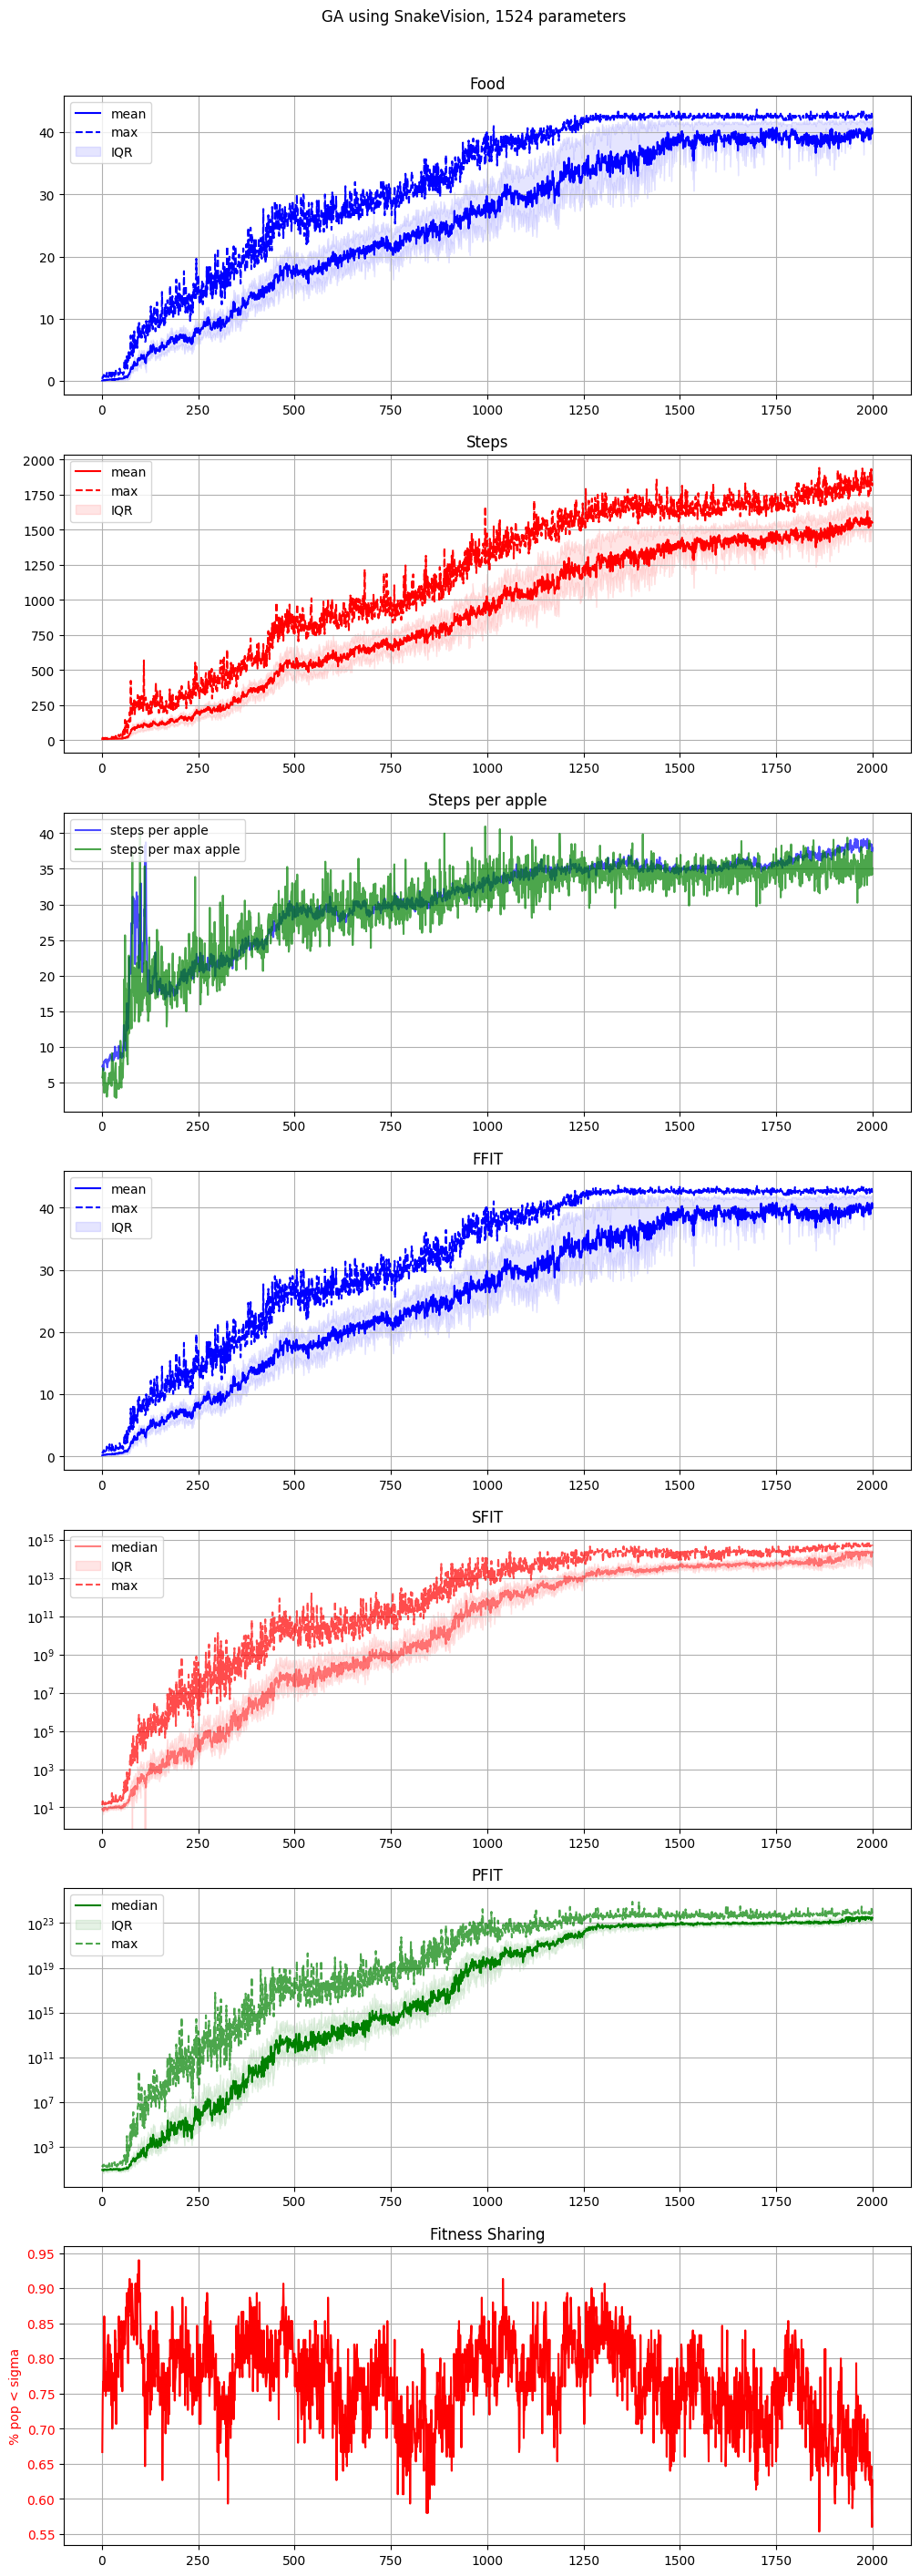

In [19]:
snake_ai = SnakeVision()
toolbox = init_toolbox()

pop, hof, logbook = setup_ga(snake_ai)
# pop, logbook = load_model(snake_ai)

# RUN GA
pop, hof, logbook = ea_mu_plus_lambda(
    pop, toolbox, hof, NGEN, MU, LAMBDA, CXPB, MUTPB, verbose=True, logbook=logbook
)

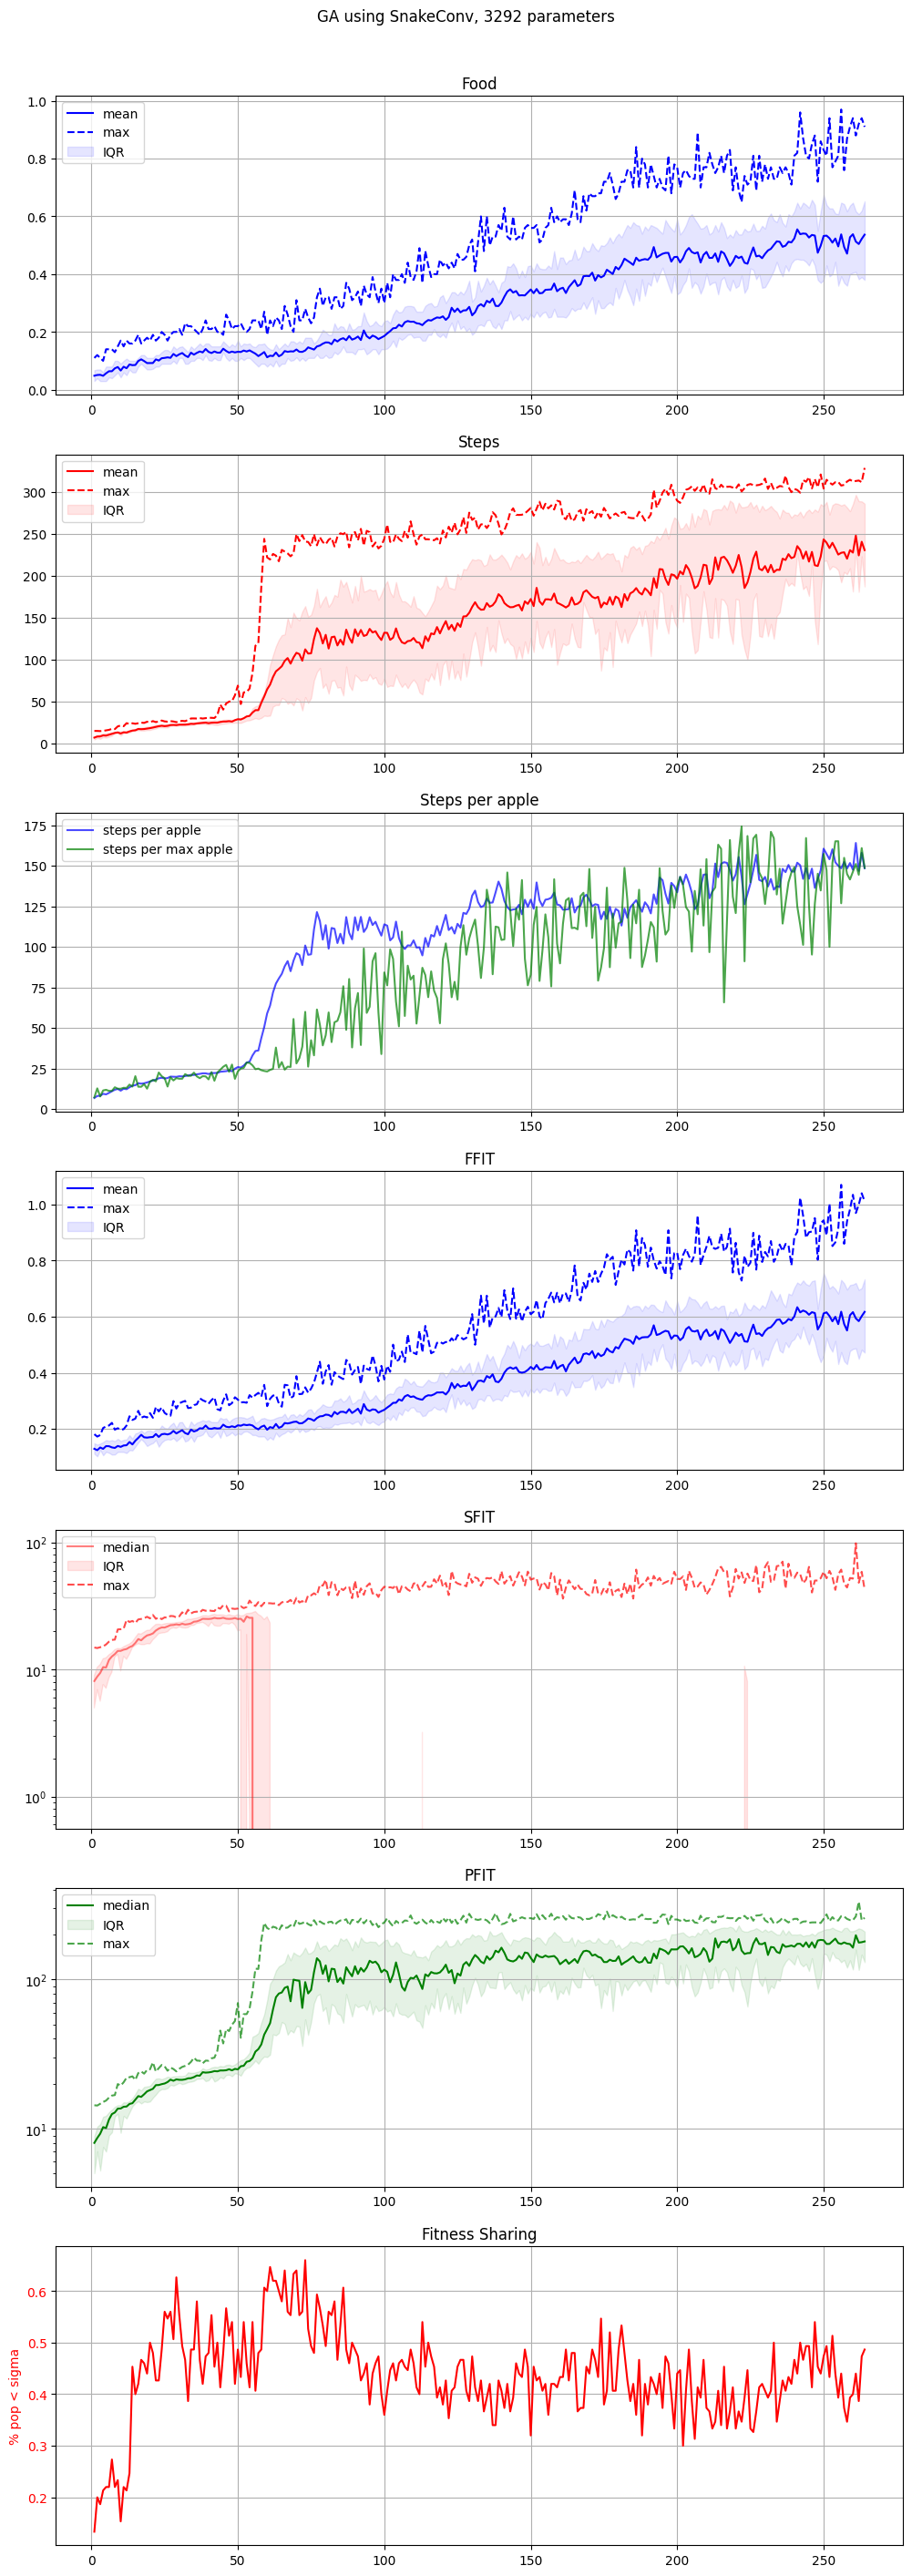

In [ ]:
snake_ai = SnakeConv()
toolbox = init_toolbox()

pop, hof, logbook = setup_ga(snake_ai)
# pop, logbook = load_model(snake_ai)

# RUN GA
pop, hof, logbook = ea_mu_plus_lambda(
    pop, toolbox, hof, NGEN, MU, LAMBDA, CXPB, MUTPB, verbose=True, logbook=logbook
)

# Q4

## Statistically Evaluating Best Indvidual

Because I am using an NSGA2 optimization, the total fitness is not a good indicator of the best individual performance. Since our overarching objective is max number of apples, I will be evaluating the best individual based on their mean food score over 10 games.

I will then statistically evaluate the top indiviudals performance over 100 games and give the mean score and a 5% confidence interval for the max score the indiviudal will achieve in 5 games. I will also assess whether the model can still improve or has reached a locally optimal strategy.

I will be using `SnakeVision` in my evaluation as it performs better than `SnakeConv`.

### Alternative objectives

I am primarily evaluating for max food, other objectives could be:

- Avg food per steps: This is difficult because as the snake eats more food and its length increases, it requires more steps to eat the next apple
    - As the length increases, it requires a longer time to eat the next apple, so this will only reward snakes that eat less apples.
- Population strategy diversity: Not a statistical target per se, but I'd like to explore the population of best individuals to find if they all converge on a single "optimal" strategy, or alternate strategies
    - I think this fairly difficult to quantify, perhaps using the *change in fitness sharing over time* could indicate a convergence towards a single strategy.
    - This still may not be useful, because it is used in the training procedure as a penalty. The highest fitness individuals must have different chromosomes, at least in the fitness sharing measures. This may not mean they don't still have the same behaviour.
    - "When a measure becomes a target it ceases to be a good measure"

## Vision vs Conv

The conv model has extrememely poor performance, both in inference speed and learning rate. The vision model both learns quicker and results in a higher overall max and average score. For this reason I will be using the vision model to perfom the statistical tests, but this can also be run with the CNN.

In [22]:
_, vision_logbook = load_model(SnakeVision())
_, conv_logbook = load_model(SnakeConv())

vision_gens = vision_logbook.select("gen")
vision_food = vision_logbook.select("food_avg")

conv_gens = conv_logbook.select("gen")
conv_food = conv_logbook.select("food_avg")


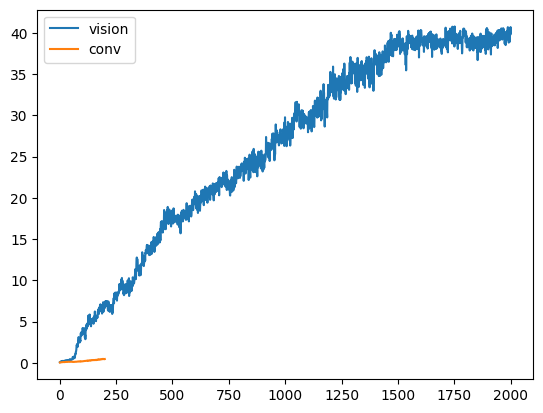

In [23]:
plt.plot(vision_gens, vision_food, label="vision")
plt.plot(conv_gens, conv_food, label="conv")
plt.legend()
plt.show()

## Evaluating Best Indiviudal

In this section I will statistically evaluate the performance of the best individual over 100 games.

### Picking Best Individual

I sort the population by `get_food_fitness`, which is the mean number of apples. Importantly, this metric will not be infulenced by fitness sharing. 

In [24]:
snake_ai = SnakeVision()
setup_ga(snake_ai)
pop, logbook = load_model(snake_ai)
toolbox = init_toolbox()

In [25]:
NRUNS = 10 # Increased to eliminate some randomness

fitnesses = toolbox.map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
    
# weird python magic here, attrgetter returns a callable for fitness.get_food_fitness but needs
# an object to call it on (x). The function is then run with the final ().
sorted_pop = sorted(
    pop, key=lambda x: x.fitness.stats['score'], reverse=True
)

best_ind = sorted_pop[0]
print(f"found best individual, with average food {best_ind.fitness.stats['score']}")

found best individual, with average food 42.3


In [26]:
NRUNS = 100
best_ind.fitness.values = toolbox.evaluate(best_ind, save_data=True)
res_stats = best_ind.fitness.evaluate_results
scores = np.array(res_stats['score'])
gens = np.arange(0, len(scores))

The scores of the best indiviudal do not follow a normal distribution


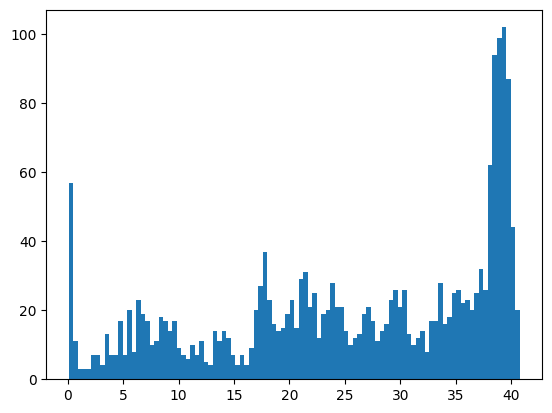

In [34]:
print("The scores of the best indiviudal do not follow a normal distribution")
plt.hist(scores, bins=100)
plt.show()

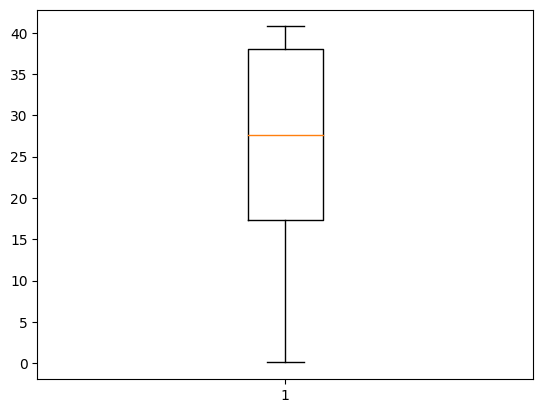

In [35]:
# visualize results of the scores
plt.boxplot(scores)
plt.show()

#### If the best indiviudual was run 5 times, what value would we expect the max value to be with a 95% confidence?

The scores do not follow a normal distribution, but we can computationally calculate an approximate best score given 5 runs, by resampling the data into bins of 5 runs. We can then take the lower 5% quantile as a confidence interval.

In [36]:
# we need the best of 5 scores, so we can use the max of 5 random samples of the distribution
# repeated 10000 times, then take confidence interval
aug_n = 10000
k = 5  # games
augmented_scores = []
conf_interval = 0.05

for _ in range(aug_n):
    # each score is independent
    rand_scores = np.random.choice(scores, size=k, replace=True)
    augmented_scores.append(np.max(rand_scores))

lower_bound = np.quantile(augmented_scores, conf_interval)

print(
    f"Max score with {k} tries at a {conf_interval} confidence interval: {lower_bound}"
)


Max score with 5 tries at a 0.05 confidence interval: 30.10666666666667


## Evaluating Training

I will now evaluate the training of the entire population, to assess whether the population has found a local optimum or if it can continue to improve.

From the training graphs, we can see that the population improved consistently and smoothly, making large jumps in fitness but slowing down towards the end of the generations.

In the final training run, all 3 objective are smoothly increasing throughout, almost in sync with each other. This was a problem I had with larger models, even adding an extra 32 layer to the vision model caused the population to regress significantly: the model would learn that an easy way to optimize the PFIT objective is to get 1 or 2 apples and die as soon as eating it, to maximize the ratio. This causes the average SFIT score to nose dive as it should do, the snakes wouldn't take any steps after eating the last food. This segregates the population in two: half the population is optimized to die after it can't easily get the next apple, and half is trying to increase step count. In many experiments this caused stagnation and the models would not improve after the 50th generation. This taught me the value of having aligned objectives, even in multiple objective optimisation. It was quite a suprising discovery for me as I naively thought that more layers = better, but at least for GAs this isn't the case.

The hardest stage in the training I found was breaking the threshold of 3-4 apples

---

I cannot use ttest or anova because the samples of my mean scores are not independant and there is a temporal aspect to the training (generation fitness relies on previous generation)

In [37]:
gens = vision_logbook.select('gen')
scores = vision_logbook.select('food_avg')
food_max = vision_logbook.select('food_max')

### Linear / Polynomial Regression

Linear regression his will model the relationship between generation and scores, given a linear relationship between gens and score. This can also allow me to extrapolate to future. However, I belive training will likely fit a polynomial regression fit, as snake reaches its max fitness.

The regression below shows that the training improvement is now slowing, and we might of be close to an optimal representation of the NN.

We can also see the max score plateued at ~1250 generations, with the average score converging to it. This is a good indication of reaching the local maxima for this NN.

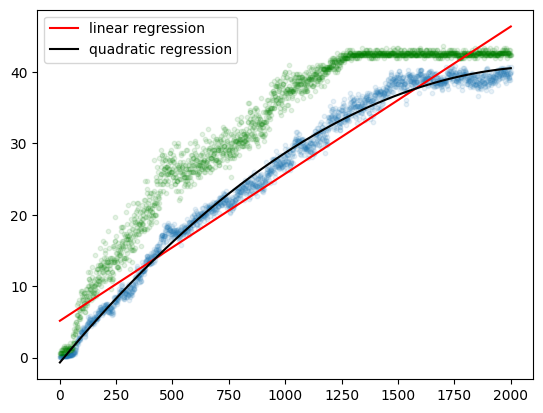

In [38]:
lin_c = np.polyfit(gens, scores, deg=1)
lin_fit = np.polyval(lin_c, gens)

quad_c = np.polyfit(gens, scores, deg=2)
quad_fit = np.polyval(quad_c, gens)

plt.scatter(gens, scores, alpha=0.1, s=10, zorder=1)
plt.scatter(gens, food_max, alpha=0.1, s=10, zorder=1, c="green")
plt.plot(gens, lin_fit, label="linear regression", color='red', zorder=10)
plt.plot(gens, quad_fit, label="quadratic regression", color='black', zorder=10)
plt.legend()
plt.show()

## Moving Window Average

This smooths short term fluctuations and noise from the score data. Can be used to further identify trends, I will use this to identify change points.

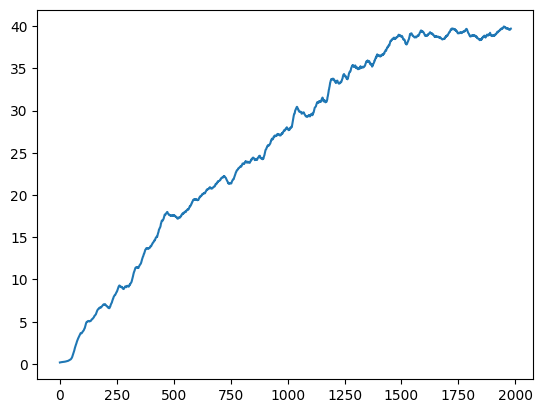

In [39]:
window_size = 20
# will be shorter than x
# convulation over x
kernel = np.ones(window_size)/window_size # array sums to 1
moving_average = np.convolve(scores, kernel, mode='valid')
plt.plot(np.arange(len(moving_average)), moving_average)
plt.show()

## Change Point Detection

Identifies where the score changes significantly, using moving window. I am using moving window to smooth out any random changes generation to generation

We can see there is no change points in the last 500 generations, which further indicates that the model is no longer improving significantly. I believe this is as optimal as the vision NN will get without architectual changes.

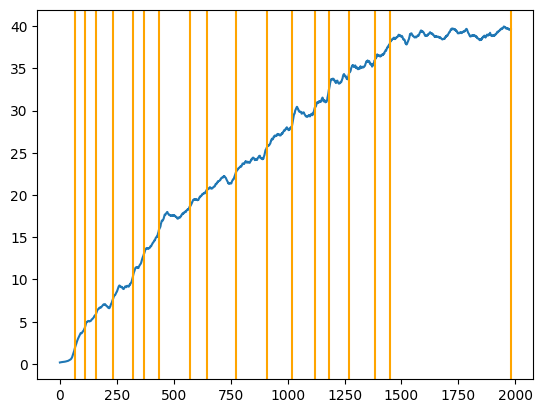

In [40]:
algorithm = rpt.Pelt(model="l2")
change_points = algorithm.fit_predict(moving_average, pen=50)

plt.plot(np.arange(len(moving_average)), moving_average)
for p in change_points:
    plt.axvline(p, color='orange')
plt.show()

# Q5

Through my experiments and research I found that a simpler representation of the snake was more effective for GA training than a more complex model. I found that for this problem, the vision model MLP was the most effective. Using a pareto front to balance the objectives was also very effective, and I found that the population was able to converge on a good solution.

The number of parameters used for a GA model is very significant, and I found increasing them increases the training time signficantly. Designing a compact model with few input parameters is important to reduce the training time.

I found that the CNN network was quite a dissapointment, and that the vision model was much more effective. I believe this is because the vision model is a much simpler model, with less parameters, and simpler architecture to optimize. I spent a significant amount of time trying to optimize the CNN model, but it was still significantly slower than the vision model.

I also discovered an appreciation for fitness evaluation, and how it can be used to guide the training process. My initial experiments were quite naive, where the snake AIs would find interesting and novel behaviours to optimize my fitness functions, not in the ways that I intended:

- The snake would learn to die instantly, to minimize the number of steps taken.
- The snake would learn to die after eating an apple, to maximize the ratio of food to steps
- The snakes would loop, in order to maximize the number of steps taken
- The snakes would learn to move all the way up to the apple without eating it, in order to maximize the distance to apple, the ratio of apples to steps and number of steps after the last apple.

Through these experimental frustrations I found that clearly defining the objectives of the function to optimize was similar to me in nature to debugging a program. The plots logging the behaviour I found essential to understanding where the model was going wrong, and how to fix it. NSGA-II and pareto fronts were also very useful in this regard, as it allowed me to balance the objectives.

I found that the fitness sharing was a very useful tool to prevent the population from converging on a single strategy, and that the fitness sharing was also a good indicator of the population's diversity.

I found giving yourself stats and visual plots is a very useful tool to help understand your model and its training process, for instance in the bad CNN training run above, the steps and food are still slowly increasing, so it is not obvious form those main plots that the model is regressing.

I found normalization of inputs to be important, as the example I gave earlier where I gave the angle to the food 0-360, and this overpowered the other inputs which were 0-16 at the time.

## Future work

- Training a larger model. This takes longer, is slower but may if trained long enough be able to find a better solution
- combine the CNN network with the vision. I do like the CNN as it gives the model the option of capturing whatever detail it wants, rather than the hand coded features from the vision model.
- Using reinforcement learning and backpropagation, and comparing this to the GA.
- Using an adversarial network to train the snake by placing apples, as the snake gets better the adversarial network could place the apples in more difficult positions.
